# Pump It Up Data Competition
## Buckley Dowdle and Michael Pajewski
### Competition: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

## Section 1 Data Exploration and Wrangling

In [1]:
#imports
import numpy as np 
import pandas as pd 
from scipy import stats
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

#load data
train_x = pd.read_csv('TrainingSetValues.csv')
train_y = pd.read_csv('TrainingSetLabels.csv')
train = pd.merge(train_y,train_x, how='left', left_on = 'id', right_on='id')

test_x = pd.read_csv('TestSetValues.csv')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-hnm3ltf1 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### First, what is the response variable and how balanced is it?

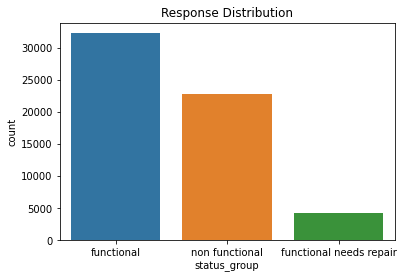

In [2]:
train.status_group.value_counts()
sns.countplot(x="status_group", data=train)
plt.title('Response Distribution');

#### We can see below there are three possibilities for the response and it is highly skewed. This is an early indicator that we will need to use a tree based algorithm, conduct stratified sampling, or upsample the underrepresented classes to achieve acceptable prediction accuracy.

#### There are also multiple columns denoting the same or similar information as one another. We remove those columns below.

In [3]:
#denote columns to keep
col_to_drop = ['scheme_management', 'quantity_group', 'water_quality', 
               'payment_type', 'extraction_type', 'waterpoint_type_group', 
               'region_code', 'date_recorded', 'recorded_by']
#drop dolumns
train = train.drop(col_to_drop, axis = 1)

#### Next, which columns contain empty cells?

In [4]:
train.isnull().sum()/len(train.id)*100

id                        0.000000
status_group              0.000000
amount_tsh                0.000000
funder                    6.119529
gps_height                0.000000
installer                 6.153199
longitude                 0.000000
latitude                  0.000000
wpt_name                  0.000000
num_private               0.000000
basin                     0.000000
subvillage                0.624579
region                    0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.612795
scheme_name              47.417508
permit                    5.144781
construction_year         0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group          0.000000
payment                   0.000000
quality_group             0.000000
quantity                  0.000000
source              

#### Most of the columns appear to be in good shape, but we will have some impuation to do later. While most of the columns do not have null cells theu could be using other codes for missing values. We've checked them all individually, but we'll show  longitude below as an example

In [5]:
train.longitude.value_counts()

0.000000     1812
32.977191       2
32.919861       2
37.542785       2
39.105307       2
             ... 
37.141893       1
35.839879       1
33.638301       1
35.347266       1
35.164770       1
Name: longitude, Length: 57516, dtype: int64

#### We see that 0 is used 1800 times while the next closest is used only twice. This is missing data that we will need to impute. Again, there are other features with similar issues that we will fix, this is just a single example

#### We also see that installer and funder have around 2,000 categories each and that many of these appear only once. To work around this, we'll group any categories with less than 100 occurances into a new category called "other".

In [6]:
train.installer.value_counts()

DWE                        17402
Government                  1825
RWE                         1206
Commu                       1060
DANIDA                      1050
                           ...  
Kuweit                         1
Billy Phillips                 1
Noshadi                        1
Pump entecostal Sweeden        1
GGM                            1
Name: installer, Length: 2145, dtype: int64

In [8]:
#make string columns lowercase
train['installer'] = train.installer.str.lower()
train['funder'] = train.funder.str.lower()

#replace 0 w/ other in funder column
train['funder'] = train['funder'].replace('0', 'other')

#generate an index of funders w/ more than 100 pumps
funder_over_100 = train.groupby('funder')['status_group'].count().apply(lambda g: g>100)
funder_over_100 = funder_over_100[funder_over_100].index

#relabel all funders w/ less than 100 pumps 'other'
train['funder'] = train.apply(lambda row: row['funder'] if row['funder'] in funder_over_100 else 'other', axis = 1)

#replace 0 w/ other in installer column
train['installer'] = train['installer'].replace('0', 'other')

#generate an index of funders w/ more than 100 pumps
installer_over_100 = train.groupby('installer')['status_group'].count().apply(lambda g: g>100)
installer_over_100 = installer_over_100[installer_over_100].index

#relabel all installers w/ less than 100 pumps 'other'
train['installer'] = train.apply(lambda row: row['installer'] if row['installer'] in installer_over_100 else 'other', axis = 1)

#### For imputation purposes, we need to find the mean of certain numerical columns, grouped by another column. Before we do this, we need to create a dataframe that filters out the bad data. This will allow us to compute the true mean of the column without including the 0s.

In [9]:
#copies of dataframe without 0s in each of the 4 columns
train_lat_not_missing = train[train.latitude != -2.000000e-08]
train_lon_not_missing = train[train.longitude != 0]
train_year_not_missing = train[train.construction_year != 0]
train_pop_not_missing = train[train.population != 0]

In [10]:
#for each of the columns below, we will find the mode (for categorical variables) or mean (for continuous variables) by region or basin. These modes/means will be used to fill in missing values

scheme_name_modes = pd.DataFrame(train.groupby('region').scheme_name.apply(lambda x: x.mode())).reset_index().drop('level_1', axis=1).set_index('region')['scheme_name'].to_dict()

subvillage_modes = pd.DataFrame(train.groupby('region').subvillage.apply(lambda x: x.mode())).reset_index().drop('level_1', axis=1).set_index('region')['subvillage'].to_dict()

permit_modes = pd.DataFrame(train.groupby('region').permit.apply(lambda x: x.mode())).reset_index().drop('level_1', axis=1).set_index('region')['permit'].to_dict()

public_meeting_modes = pd.DataFrame(train.groupby('region').public_meeting.apply(lambda x: x.mode())).reset_index().drop('level_1', axis=1).set_index('region')['public_meeting'].to_dict()

latitude_means = pd.DataFrame(train_lat_not_missing.groupby('region').latitude.apply(lambda x: x.mean())).reset_index().set_index('region')['latitude'].to_dict()

longitude_means = pd.DataFrame(train_lon_not_missing.groupby('region').longitude.apply(lambda x: x.mean())).reset_index().set_index('region')['longitude'].to_dict()

population_means = pd.DataFrame(train_pop_not_missing.groupby('basin').population.apply(lambda x: int(x.mean()))).reset_index().set_index('basin')['population'].to_dict()

construction_year_means = pd.DataFrame(train_year_not_missing.groupby('basin').construction_year.apply(lambda x: int(x.mean()))).reset_index().set_index('basin')['construction_year'].to_dict()

In [11]:
#here we map the modes of missing categorical variables by region to missing cells
train.scheme_name = train.scheme_name.fillna(train.region.map(scheme_name_modes))

train.subvillage = train.subvillage.fillna(train.region.map(subvillage_modes))

train.permit = train.permit.fillna(train.region.map(permit_modes))

train.public_meeting = train.public_meeting.fillna(train.region.map(public_meeting_modes))

In [12]:
#here we map the means of missing continuous variables by region to missing cells

train.latitude = train.apply(lambda row: latitude_means[row.region] if row.latitude ==  -2.000000e-08 else row.latitude, axis=1)

train.longitude = train.apply(lambda row: longitude_means[row.region] if row.longitude ==  0 else row.longitude, axis=1)

train.construction_year = train.apply(lambda row: construction_year_means[row.basin] if row.construction_year ==  0 else row.construction_year, axis=1)

train.population = train.apply(lambda row: population_means[row.basin] if row.population ==  0 else row.population, axis=1)

## Now, we can do one last quick check of the data to ensure everything is as we intended.

In [13]:
profile = ProfileReport(train)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/45 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Do we need more in depth data exploration?
#### In this case, probably not. We have decided at this point to use a gradient boosted tree algorithm that will select features automatically. If our initial performance is not acceptable, we may return to this phase of the project to conduct feature engineering.

### Now we need to repeat the above transformations on the test data set.

In [14]:
#drop columns
test_x = test_x.drop(col_to_drop, axis = 1)

#make string columns lowercase
test_x['installer'] = test_x.installer.str.lower()
test_x['funder'] = test_x.funder.str.lower()

#replace 0 w/ other in funder column
test_x['funder'] = test_x['funder'].replace('0', 'other')

#relabel all funders w/ less than 100 pumps 'other'
test_x['funder'] = test_x.apply(lambda row: row['funder'] if row['funder'] in funder_over_100 else 'other', axis = 1)

#replace 0 w/ other in installer column
test_x['installer'] = test_x['installer'].replace('0', 'other')

#relabel all installers w/ less than 100 pumps 'other'
test_x['installer'] = test_x.apply(lambda row: row['installer'] if row['installer'] in installer_over_100 else 'other', axis = 1)

#here we map the modes of missing categorical variables by region to missing cells
test_x.scheme_name = test_x.scheme_name.fillna(test_x.region.map(scheme_name_modes))

test_x.subvillage = test_x.subvillage.fillna(test_x.region.map(subvillage_modes))

test_x.permit = test_x.permit.fillna(test_x.region.map(permit_modes))

test_x.public_meeting = test_x.public_meeting.fillna(test_x.region.map(public_meeting_modes))

#here we map the means of missing continuous variables by region to missing cells

test_x.latitude = test_x.apply(lambda row: latitude_means[row.region] if row.latitude ==  -2.000000e-08 else row.latitude, axis=1)

test_x.longitude = train.apply(lambda row: longitude_means[row.region] if row.longitude ==  0 else row.longitude, axis=1)

test_x.construction_year = test_x.apply(lambda row: construction_year_means[row.basin] if row.construction_year ==  0 else row.construction_year, axis=1)

test_x.population = test_x.apply(lambda row: population_means[row.basin] if row.population ==  0 else row.population, axis=1)

In [18]:
test_x.to_csv('test3.0.csv', index=False)
train.to_csv('train3.0.csv', index=False)